In [27]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# Import data

In [28]:
img_dim = 224
image_size = (img_dim, img_dim, 3)
epochs = 20
batch_size = 16

In [29]:
train_dataGenerator = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.3,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
)


val_dataGenerator = ImageDataGenerator(
    rescale=1. / 255)

In [30]:
# This is fed to the network in the specified batch sizes and image dimensions
train_gen = train_dataGenerator.flow_from_directory(
    directory='training',
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
     classes = ['surface']
)

val_gen = val_dataGenerator.flow_from_directory(
    directory='testing',
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
     classes = ['surface']
)


Found 1542 images belonging to 1 classes.
Found 64 images belonging to 1 classes.


# Model 

In [31]:
def backbone_model1(classes, dims):
    """
    :param classes:
    :param dims:
    :return:
    """
    inputs = tf.keras.layers.Input(shape=dims)
    # block 1
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', name='conv_1')(inputs)
    x = tf.keras.layers.Activation('relu', name='activation1')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), name='pooling_1')(x)

    # block 2
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', name='conv_2')(x)
    x = tf.keras.layers.Activation('relu', name='activation2')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), name='pooling_2')(x)

    # fully connected layers
    x = tf.keras.layers.Flatten(name='flatten_layer')(x)
    x = tf.keras.layers.Dense(64, name='dense2')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(32, name='dense3')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(classes, name='output')(x)
    x = tf.keras.layers.Activation('softmax')(x)

    back_bone_model = Model(inputs, x, name='backbone_model_features')

    return back_bone_model 

In [13]:
model = backbone_model1(2, image_size)
model.compile(optimizer='adam', loss='binary_crossentropy')


In [14]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)

history = model.fit(
           train_gen,
           epochs=1,
           validation_data=val_gen,
           callbacks=[checkpoint])

model.save('model.h5')


97/97 [==============================] - 207s 2s/step - loss: 0.0074 - val_loss: 0.0000e+00


# Test the model

In [21]:
model = load_model('model.h5')
model.load_weights("best_weights.hdf5")

surface_image =  'surface.jpg'
no_surface_image =  'images.jpg'


def read_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array.astype('float32') / 255
    return np.expand_dims(img_array, axis=0)


right_class = model.predict(read_img(surface_image))
fals_class = model.predict(read_img(no_surface_image))

print("The probability that the image is a surface is {}".format(np.argmax(right_class)))
print("The probability that the image is a not a surface is {}".format( np.argmax(fals_class)))


The probability that the image is a surface is 1
The probability that the image is a not a surface is 1


In [22]:
right_class

array([[1.8765633e-19, 1.0000000e+00]], dtype=float32)

In [23]:
fals_class

array([[0., 1.]], dtype=float32)

# visualize Feature Maps

In [17]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input_2',
 'conv_1',
 'activation1',
 'pooling_1',
 'conv_2',
 'activation2',
 'pooling_2',
 'flatten_layer',
 'dense1',
 'activation_1',
 'dense2',
 'activation_2',
 'dense3',
 'activation_3',
 'output',
 'activation_4']

In [18]:
model.layers


In [19]:
layer_outputs = [layer.output for layer in model.layers]


In [20]:
feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)


In [21]:
feature_maps = feature_map_model.predict((read_img(no_surface_image)))


In [22]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")


The shape of the input_2 is =======>> (1, 300, 300, 3)
The shape of the conv_1 is =======>> (1, 300, 300, 128)
The shape of the activation1 is =======>> (1, 300, 300, 128)
The shape of the pooling_1 is =======>> (1, 150, 150, 128)
The shape of the conv_2 is =======>> (1, 150, 150, 64)
The shape of the activation2 is =======>> (1, 150, 150, 64)
The shape of the pooling_2 is =======>> (1, 75, 75, 64)
The shape of the flatten_layer is =======>> (1, 360000)
The shape of the dense1 is =======>> (1, 128)
The shape of the activation_1 is =======>> (1, 128)
The shape of the dense2 is =======>> (1, 64)
The shape of the activation_2 is =======>> (1, 64)
The shape of the dense3 is =======>> (1, 32)
The shape of the activation_3 is =======>> (1, 32)
The shape of the output is =======>> (1, 2)
The shape of the activation_4 is =======>> (1, 2)


C:\Users\SUPERN~1\AppData\Local\Temp/ipykernel_4892/446660761.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure( figsize=(scale * channels, scale) )
C:\Users\SUPERN~1\AppData\Local\Temp/ipykernel_4892/446660761.py:9: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


MemoryError: Unable to allocate 11.0 MiB for an array with shape (150, 9600) and data type float64

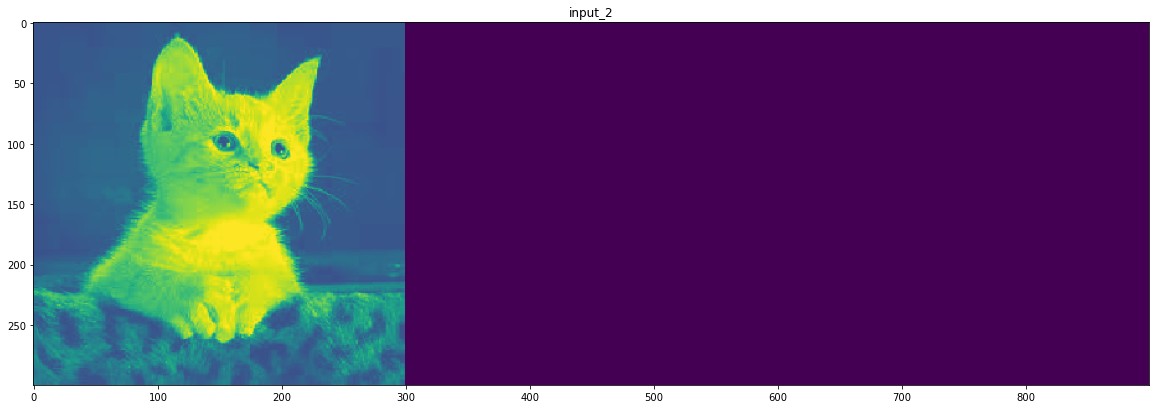

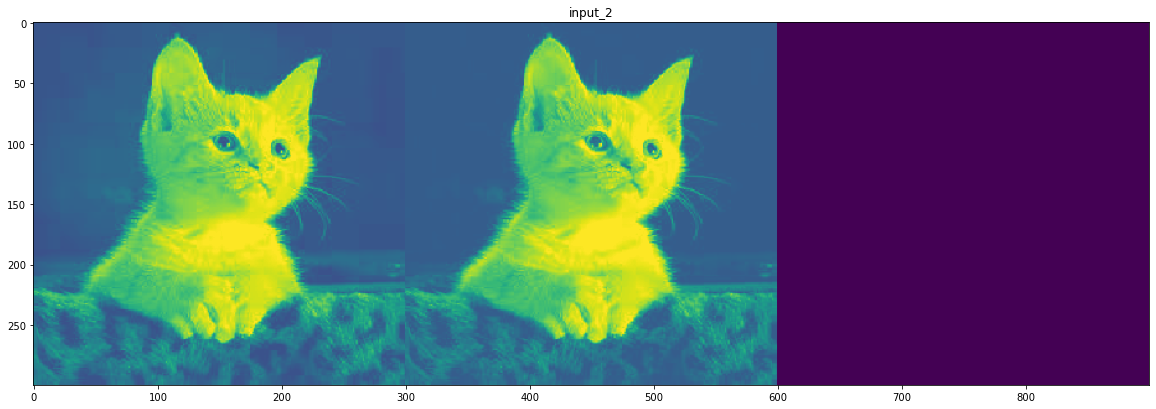

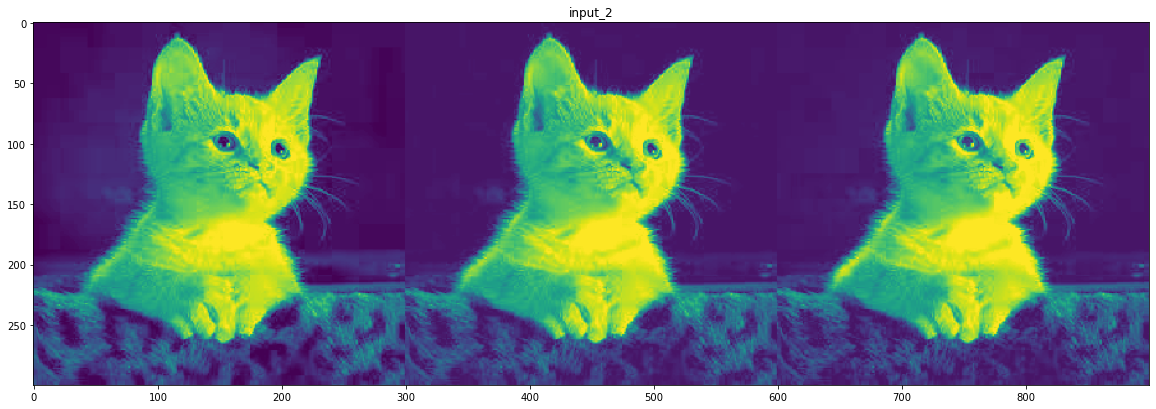

MemoryError: Unable to allocate 87.9 MiB for an array with shape (300, 38400) and data type float64

<Figure size 1440x11.25 with 1 Axes>

MemoryError: Unable to allocate 87.9 MiB for an array with shape (300, 38400) and data type float64

<Figure size 1440x11.25 with 1 Axes>

MemoryError: Unable to allocate 87.9 MiB for an array with shape (300, 38400) and data type float64

<Figure size 1440x11.25 with 1 Axes>

In [ ]:
for layer_name, feature_map in zip(layer_names, feature_maps):  
    if len(feature_map.shape) == 4:
        channels = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size*channels))
        for i in range(channels):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x    
            
            scale = 20./ channels
            plt.figure( figsize=(scale * channels, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto')
